<h1 style="text-align: center;">Speech Emotion Recognition in TinyML</h1>

In [1]:
import os
import sys
import time
from IPython.display import Audio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# Change integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 
                             5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, 
                            inplace=True)
Ravdess_df.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


In [4]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []
for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,fear,/kaggle/input/toronto-emotional-speech-set-tes...
1,fear,/kaggle/input/toronto-emotional-speech-set-tes...
2,fear,/kaggle/input/toronto-emotional-speech-set-tes...
3,fear,/kaggle/input/toronto-emotional-speech-set-tes...
4,fear,/kaggle/input/toronto-emotional-speech-set-tes...


In [5]:
savee_directory_list = os.listdir(Savee)
file_emotion = []
file_path = []
for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
1,fear,/kaggle/input/surrey-audiovisual-expressed-emo...
2,happy,/kaggle/input/surrey-audiovisual-expressed-emo...
3,disgust,/kaggle/input/surrey-audiovisual-expressed-emo...
4,angry,/kaggle/input/surrey-audiovisual-expressed-emo...


In [6]:
aggregated_data = pd.concat([Ravdess_df, Tess_df, Savee_df], axis = 0)
# Shuffle the dataframe using the sample method
aggregated_data = aggregated_data.sample(frac=1).reset_index(drop=True) 
# Drop rows where Emotions is 'fear' or 'disgust'
aggregated_data = aggregated_data[~aggregated_data['Emotions'].isin(['fear', 'disgust'])]
# Drop rows where Emotions is "sad" and "angry" and replace them with "unpleasant"
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'sad'].sample(frac=0.4).index)
aggregated_data = aggregated_data.drop(aggregated_data[aggregated_data['Emotions'] == 'angry'].sample(frac=0.4).index)
aggregated_data['Emotions'] = aggregated_data['Emotions'].replace(['sad', 'angry'], 'unpleasant')
aggregated_data.to_csv("data_path.csv",index=False)
aggregated_data.head()

,Emotions,Path
1,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
2,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
3,unpleasant,/kaggle/input/toronto-emotional-speech-set-tes...
4,surprise,/kaggle/input/toronto-emotional-speech-set-tes...
7,surprise,/kaggle/input/toronto-emotional-speech-set-tes...


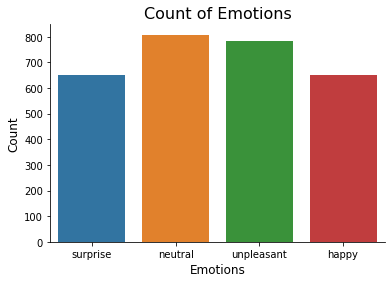

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(aggregated_data.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

## Data Exploration

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()
def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

In [9]:
def noise(data):
    noise_amp = 0.5*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

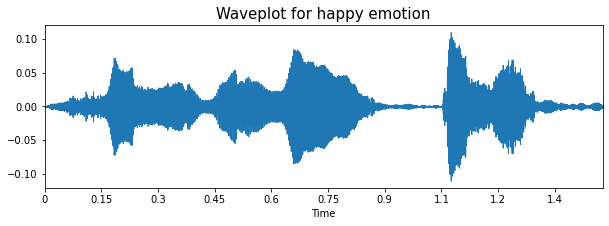

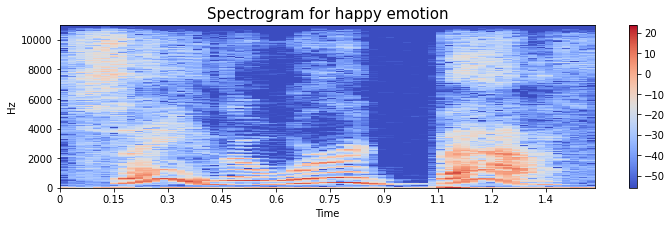

In [10]:
emotion='happy'
path = np.array(aggregated_data.Path[aggregated_data.Emotions==emotion])[1]
data, sample_rate = librosa.load(path)
data = librosa.resample(data, sample_rate, 16000)
noised_data = noise(data)
create_waveplot(data, sample_rate, emotion)
create_spectrogram(data, sample_rate, emotion)
Audio(data=noised_data, rate=16000)
# Key Speech Element Span
# Ravdess_df: 0.8-2.8s -> 2.0s
#    Tess_df: 0.3-1.8s -> 1.5s
#   Savee_df: 0.6-3.3s -> 2.7s

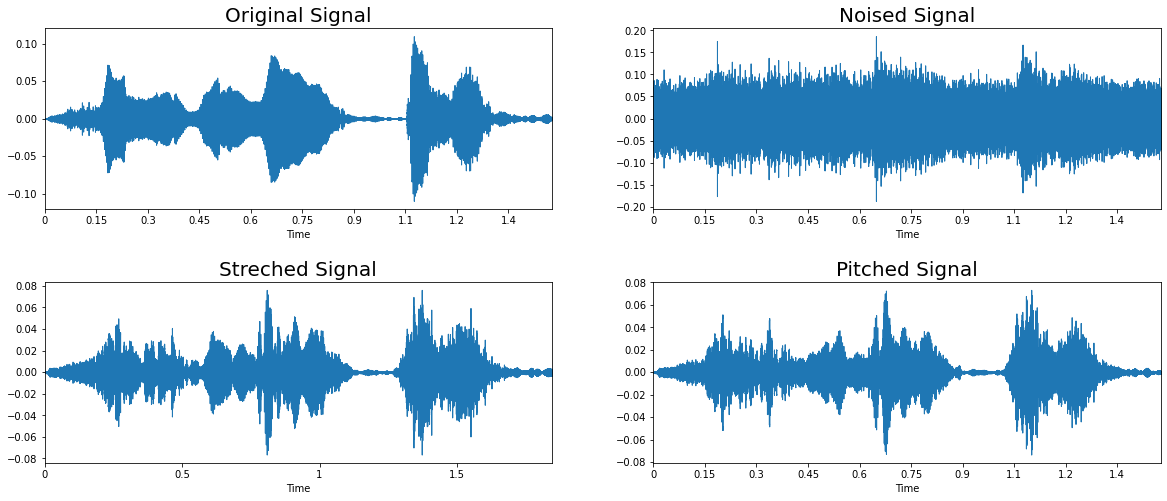

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(20,8))
plt.subplots_adjust(hspace=0.4)
axs[0, 0].set_title('Original Signal', size=20)
librosa.display.waveplot(y=data, sr=sample_rate, ax=axs[0, 0])
axs[0, 1].set_title('Noised Signal', size=20)
noise_data = noise(data)
librosa.display.waveplot(y=noise_data, sr=sample_rate, ax=axs[0, 1])
axs[1, 0].set_title('Streched Signal', size=20)
stretch_data = stretch(data)
librosa.display.waveplot(y=stretch_data, sr=sample_rate, ax=axs[1, 0])
axs[1, 1].set_title('Pitched Signal', size=20)
pitch_data = pitch(data, sample_rate)
librosa.display.waveplot(y=pitch_data, sr=sample_rate, ax=axs[1, 1])
plt.show()

## Data Pre-processing

In [12]:
labels = {'neutral':0, 'happy':1, 'surprise':2, 'unpleasant': 3}
aggregated_data.replace({'Emotions':labels},inplace=True)
aggregated_data.head()

,Emotions,Path
1,2,/kaggle/input/ravdess-emotional-speech-audio/a...
2,0,/kaggle/input/ravdess-emotional-speech-audio/a...
3,3,/kaggle/input/toronto-emotional-speech-set-tes...
4,2,/kaggle/input/toronto-emotional-speech-set-tes...
7,2,/kaggle/input/toronto-emotional-speech-set-tes...


In [13]:
NUM_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
SAMPLE_RATE = 22050
DOWN_SAMPLE_RATE = 16000
SAMPLE_NUM = aggregated_data.shape[0]
data = {
        "labels": [],
        "features": []
    }
def extract_features(data, sample_rate):
    mfcc = librosa.feature.mfcc(data, sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
    feature = mfcc.T
    return feature
for i in range(SAMPLE_NUM):
    for j in range(2):
        data['labels'].append(aggregated_data.iloc[i,0])
    signal, sample_rate = librosa.load(aggregated_data.iloc[i,1], sr=SAMPLE_RATE)
    # Cropping & Resampling
    start_time = 0.4  # Start time in seconds
    end_time = 1.9  # End time in seconds
    start_frame = int(start_time * sample_rate)
    end_frame = int(end_time * sample_rate)
    signal = signal[start_frame:end_frame]
    signal = librosa.resample(signal, sample_rate, DOWN_SAMPLE_RATE)
    # Add noise
    signal = noise(signal)
    res1 = extract_features(signal, DOWN_SAMPLE_RATE)
    data["features"].append(np.array(res1))
    # Stretch and shift pitch
    new_data = stretch(signal)[:24000]
    data_stretch_pitch = pitch(new_data, DOWN_SAMPLE_RATE)
    res2 = extract_features(data_stretch_pitch, DOWN_SAMPLE_RATE)
    data["features"].append(np.array(res2))
    if i % 100 == 0:
        print(f'Processing Data: {i}/{SAMPLE_NUM}')

Processing Data: 0/2894
Processing Data: 100/2894
Processing Data: 200/2894
Processing Data: 300/2894
Processing Data: 400/2894
Processing Data: 500/2894
Processing Data: 600/2894
Processing Data: 700/2894
Processing Data: 800/2894
Processing Data: 900/2894
Processing Data: 1000/2894
Processing Data: 1100/2894
Processing Data: 1200/2894
Processing Data: 1300/2894
Processing Data: 1400/2894
Processing Data: 1500/2894
Processing Data: 1600/2894
Processing Data: 1700/2894
Processing Data: 1800/2894
Processing Data: 1900/2894
Processing Data: 2000/2894
Processing Data: 2100/2894
Processing Data: 2200/2894
Processing Data: 2300/2894
Processing Data: 2400/2894
Processing Data: 2500/2894
Processing Data: 2600/2894
Processing Data: 2700/2894
Processing Data: 2800/2894


In [14]:
Features = pd.DataFrame()
Features['features'] = data["features"]
Features['labels'] = data["labels"]
Features.to_csv('Features.csv', index=False)
Features.head()

,features,labels
0,"[[-261.4954379626807, -4.508873435640476, -4.8...",2
1,"[[-265.81158965417865, -1.9402218128346997, -9...",2
2,"[[-220.01798732432533, -5.00207702856912, 0.10...",0
3,"[[-224.9806006108427, -3.2040582058359073, -3....",0
4,"[[-147.96081728538653, -4.097606526498957, 3.2...",3


In [15]:
X = np.asarray(Features['features'])
y = np.asarray(Features["labels"])
# Pad Features to make them of equal length
X = tf.keras.preprocessing.sequence.pad_sequences(X)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)
print(f'Training Data:{X_train.shape} with label {y_train.shape}')
print(f'Validate Data:{X_validation.shape} with label {y_validation.shape}')
print(f' Testing Data:{X_test.shape} with label {y_test.shape}')

Training Data:(4167, 47, 13) with label (4167,)
Validate Data:(1042, 47, 13) with label (1042,)
 Testing Data:(579, 47, 13) with label (579,)


## Model Training

In [17]:
def build_model(input_shape):
    model = tf.keras.Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))
    return model
# Create network
input_shape = (47,13)
model = build_model(input_shape)
# Compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 47, 128)           72704     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 126,532
Trainable params: 126,532
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Run the training process
EPOCHS = 20
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=EPOCHS)

Epoch 1/20
131/131 [==============================] - 17s 101ms/step - loss: 1.3011 - accuracy: 0.3582 - val_loss: 1.1184 - val_accuracy: 0.5134
Epoch 2/20
131/131 [==============================] - 12s 88ms/step - loss: 1.1051 - accuracy: 0.4988 - val_loss: 0.9178 - val_accuracy: 0.6056
Epoch 3/20
131/131 [==============================] - 11s 88ms/step - loss: 0.9289 - accuracy: 0.5934 - val_loss: 0.8775 - val_accuracy: 0.6200
Epoch 4/20
131/131 [==============================] - 12s 90ms/step - loss: 0.8403 - accuracy: 0.6260 - val_loss: 0.7745 - val_accuracy: 0.6814
Epoch 5/20
131/131 [==============================] - 12s 89ms/step - loss: 0.7623 - accuracy: 0.6751 - val_loss: 0.8568 - val_accuracy: 0.6411
Epoch 6/20
131/131 [==============================] - 12s 89ms/step - loss: 0.7137 - accuracy: 0.6889 - val_loss: 0.7656 - val_accuracy: 0.6756
Epoch 7/20
131/131 [==============================] - 12s 91ms/step - loss: 0.6748 - accuracy: 0.7085 - val_loss: 0.7059 - val_accuracy

In [19]:
# Create a new directory called 'my_data' to store the model
output_dir = '/kaggle/working/Models'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model.save('Models/Speech-Emotion-Recognition-Model.h5')
print('Save the Tensorflow model!')

Save the Tensorflow model!


## Model Evaluation

Test Accuracy:  74.26597476005554 %


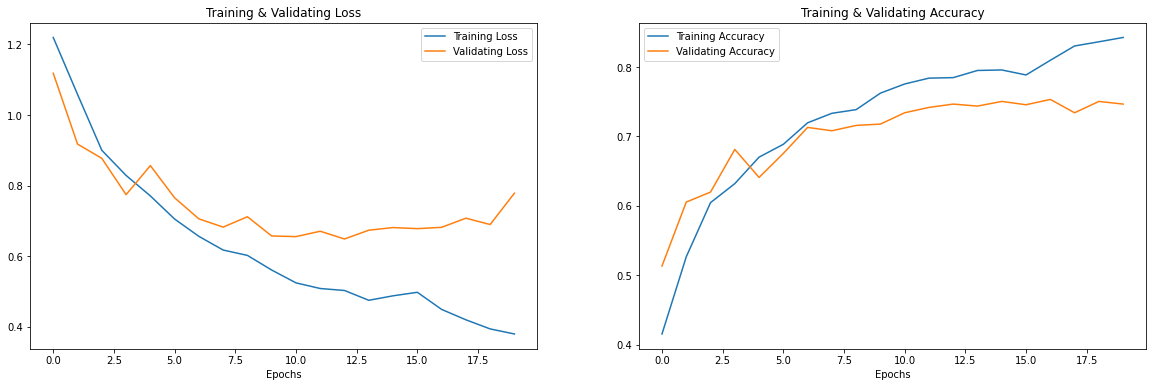

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ", test_acc*100 , "%")
epochs = [i for i in range(EPOCHS)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, val_loss, label='Validating Loss')
ax[0].set_title('Training & Validating Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, val_acc, label='Validating Accuracy')
ax[1].set_title('Training & Validating Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [21]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
label_names = list(labels.keys())
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

     neutral       0.81      0.84      0.82       174
       happy       0.69      0.73      0.71       137
    surprise       0.84      0.61      0.71       126
  unpleasant       0.66      0.75      0.70       142

    accuracy                           0.74       579
   macro avg       0.75      0.73      0.74       579
weighted avg       0.75      0.74      0.74       579



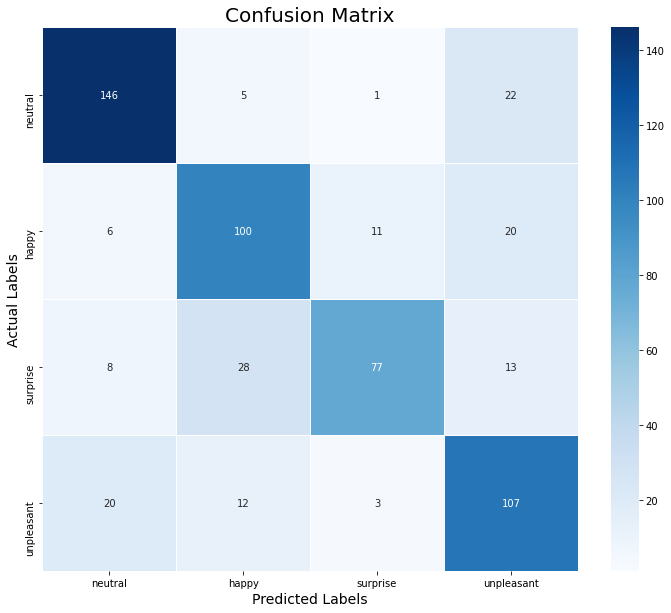

In [22]:
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm)
plt.figure(figsize = (12, 10))
sns.heatmap(cm, xticklabels=label_names, yticklabels=label_names, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

## TinyML Model Conversion & Evaluation

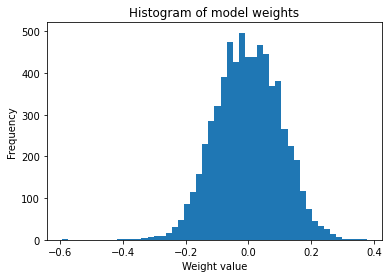

In [23]:
weights = model.get_weights()
# Plot a histogram of the weights
plt.hist(weights[0].flatten(), bins=50)
plt.xlabel('Weight value')
plt.ylabel('Frequency')
plt.title('Histogram of model weights')
plt.show()

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile("Models/SER.tflite", 'wb') as f:
   f.write(tflite_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quant_tflite_model = converter.convert()
with tf.io.gfile.GFile("Models/SER_quant.tflite", 'wb') as f:
   f.write(quant_tflite_model)
print("Save the Tensorflow 'Lite' model!")

Save the Tensorflow 'Lite' model!


In [25]:
print("Model Sizes:")
!ls -lh Models | awk '{print $5 "\t" $9}'

Model Sizes:
	
515K	SER.tflite
150K	SER_quant.tflite
1.5M	Speech-Emotion-Recognition-Model.h5


In [26]:
def evaluate_tflite(interpreter, test_data, test_label):
    # Get the input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    num_correct = 0
    num_total = 0
    # Iterate over the testing data.
    for i in range(test_data.shape[0]):
        # Get the input data for this example.
        input_data = np.array([test_data[i]], dtype=np.float32)
        # Set the input tensor.
        interpreter.set_tensor(input_details[0]['index'], input_data)
        # Run inference.
        interpreter.invoke()
        # Get the output tensor.
        output_data = interpreter.get_tensor(output_details[0]['index'])
        # Compute the predicted label.
        predicted_label = np.argmax(output_data)
        # Update the results.
        if predicted_label == test_label[i]:
            num_correct += 1
        num_total += 1
    # Reset all variables so it will not pollute other inferences.
    interpreter.reset_all_variables()
    # Compute the accuracy.
    accuracy = num_correct / num_total
    return accuracy
# Load tflite model.
interpreter = tf.lite.Interpreter(model_path="Models/SER_quant.tflite")
interpreter.allocate_tensors()
tflite_test_acc = evaluate_tflite(interpreter, X_test, y_test)
print(f"TF Lite Model Accuracy: {tflite_test_acc * 100:.2f}%")
print(f"Accuracy Difference from Original Model: {test_acc}")

TF Lite Model Accuracy: 74.27%
Accuracy Difference from Original Model: 0.7426597476005554


In [27]:
input_data = np.random.randn(1, 47, 13).astype(np.float32)
start_time = time.time()
for i in range(100):
    h5_predictions = model.predict(input_data)
h5_inference_time = time.time() - start_time
start_time = time.time()
for i in range(100):
    interpreter.set_tensor(interpreter.get_input_details()[0]['index'], input_data)
    interpreter.invoke()
    tflite_predictions = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
    interpreter.reset_all_variables()
tflite_inference_time = time.time() - start_time
print("Inference Time Comparison:")
print(f"Original Model: {h5_inference_time}s")
print(f"TF Lite Model: {tflite_inference_time}s")

Inference Time Comparison:
Original Model: 5.443805456161499s
TF Lite Model: 0.33344435691833496s


In [28]:
MODEL_TFLITE = 'Models/SER_quant.tflite'
MODEL_TFLITE_MICRO = 'Models/SER_micro.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}
print("Save the Tensorflow Lite 'Micro' model!")

Save the Tensorflow Lite 'Micro' model!
